# Example Fourier Frequency DEM Analysis

This python notebook will demonstrate the 2D Discrete Fourier Transform (DFT) applied to two gridded Digital Elevation Models (DEMs). This analysis can help highlight characteristic length scales in the natural landscape and also high-frequency noise present in the DEMs. 

For background reading see:

* Perron, J. T., Kirchner, J. W., and Dietrich, W. E.: Spectral signatures of characteristic spatial scales and nonfractal structure in landscapes, Journal of Geophysical Research, 113, 2008. [https://doi.org/10.1029/2007JF000866](https://doi.org/10.1029/2007JF000866)


* Purinton, B., and Bookhagen, B.: Validation of digital elevation models (DEMs) and geomorphic metrics on the southern Central Andean Plateau, Earth Surface Dynamics, 2017. [https://doi.org/10.5194/esurf-5-211-2017](https://doi.org/10.5194/esurf-5-211-2017)

### DEMs

To demonstrate this analysis we will use two DEMs with resolutions of 30 m:

1. The SRTM DEM: https://www2.jpl.nasa.gov/srtm/
2. The ASTER DEM: https://asterweb.jpl.nasa.gov/gdem.asp

### Requirements

The code requires the packages:

* *numpy, matplotlib, scipy, gdal*


# The Code

We start by importing some useful packages

In [1]:
# import some python packages 
import numpy as np
from scipy import stats
from osgeo import gdal
from matplotlib import pyplot as plt
import warnings

# ignore some warnings
warnings.filterwarnings('ignore')

# set figure size
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
# load in some helper functions
def loadDEM(dem):
    """
    Simple function to load a DEM as a numpy array and return the DEM 
    pixel size.
    """
    ds = gdal.Open(dem)
    band = ds.GetRasterBand(1)
    gt = ds.GetGeoTransform()
    nan = band.GetNoDataValue()

    # read as array and set NaN
    el = band.ReadAsArray().astype(float)
    el[el == nan] = np.nan
    
    # get step size
    step = gt[1]
    
    return el, step

def hillshade(array,azimuth,angle_altitude):
    """
    This function is used to generate a hillshade of the topography.
    """
    azimuth = 360.0 - azimuth 

    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi/180.
    altituderad = angle_altitude*np.pi/180.

    shaded = np.sin(altituderad)*np.sin(slope) + np.cos(altituderad)*np.cos(slope)*np.cos((azimuthrad - np.pi/2.) - aspect)

    return 255*(shaded + 1)/2

Now we'll load each DEM separately

In [3]:
# load the ASTER DEM
aster_fn='example_data/aster30m_dem.tif'
aster_dem, aster_step = loadDEM(aster_fn)
aster_hs = hillshade(aster_dem, 145, 45) # Create a hillshade for plotting

print("\nPixel size is {} m".format(aster_step))


Pixel size is 30.0 m


In [4]:
# also load the SRTM DEM
srtm_fn='example_data/srtm30m_dem.tif'
srtm_dem, srtm_step = loadDEM(srtm_fn)
srtm_hs = hillshade(srtm_dem, 145, 45) # Create a hillshade for plotting

Let's plot both DEMs side-by-side to get a quick sense of the data

Text(0.5, 1.0, 'SRTM 30m DEM')

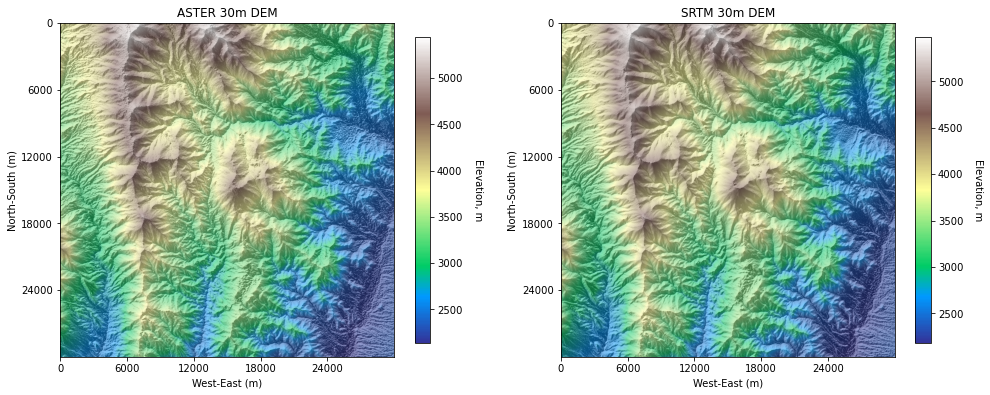

In [5]:
# instantiate a two column plot, using gridspec dictionary to make it fill up the space
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'left':0.1, 'right':0.95, 
                                                  'bottom':0.1, 'top':0.95})
# plot the DEM with hillshade
im = ax1.imshow(aster_dem, cmap='terrain') 
cbar = plt.colorbar(im, ax=ax1, shrink=0.5)
cbar.set_label('Elevation, m', rotation=270, labelpad=20)
ax1.imshow(aster_hs, cmap='Greys', alpha=0.5)
# these next lines add some labels
ax1.set_xticklabels(["{:.0f}".format(x * aster_step) for x in ax1.get_xticks()])
ax1.set_yticklabels(["{:.0f}".format(y * aster_step) for y in ax1.get_yticks()])
ax1.set_xlabel("West-East (m)")
ax1.set_ylabel("North-South (m)")
ax1.set_title('ASTER 30m DEM')

im = ax2.imshow(srtm_dem, cmap='terrain') 
cbar = plt.colorbar(im, ax=ax2, shrink=0.5)
cbar.set_label('Elevation, m', rotation=270, labelpad=20)
ax2.imshow(srtm_hs, cmap='Greys', alpha=0.5)
ax2.set_xticklabels(["{:.0f}".format(x * srtm_step) for x in ax2.get_xticks()])
ax2.set_yticklabels(["{:.0f}".format(y * srtm_step) for y in ax2.get_yticks()])
ax2.set_xlabel("West-East (m)")
ax2.set_ylabel("North-South (m)")
ax2.set_title('SRTM 30m DEM')

From this we see that the DEMs cover the same area and have similar elevation ranges. However, we may note that the ASTER DEM appears to have a slightly "grainy" texture at fine scales, whereas the SRTM appears smoother. Let's see if we can pull this out using a Fourier analysis!

**Note:** The following code is largely a translation of the MATLAB code provided in Taylor Perron's 2DSpecTools package, which is available here: http://web.mit.edu/perron/www/downloads.html

### First we set a few variables to select a DEM for analysis. We begin with the SRTM DEM

In [6]:
# set a few variables
fn = "SRTM 30m"
z = srtm_dem
hs = srtm_hs
step = srtm_step
skip = 1 # plot every n-th power value, for large grids (>2000*2000 pixels) use a skip of 2 or 3

### Pre-process the grid

In [7]:
# get the size of the raster and save a copy of the original grid
z_original = z.copy()
ny, nx = z.shape

# use linear algebra to fit a plane by least squares
x, y = np.meshgrid(range(nx), range(ny))
A = np.vstack([x.ravel(), y.ravel(), np.ones(len(x.ravel()))]).T
fit = np.linalg.lstsq(A, z.ravel(), rcond=None)[0]
z = z - (fit[0]*x + fit[1]*y + fit[2])

In [8]:
# apply hanning windowing to reduce spectral leakage on edges
hann_y = np.hanning(ny)
hann_x = np.hanning(nx)
hann_2d = np.sqrt(np.outer(hann_y, hann_x))
hann_weight = np.sum(hann_2d ** 2)
z = z * hann_2d

In [9]:
# This next step is done to optimize the Cooley and Turkey (1965) 
# Discrete Fourier Transfom (DFT) method used by numpy, which operates 
# most efficiently when the length scales are powers of 2 and the grid
# is square
Lx = int(2**(np.ceil(np.log(np.max((nx, ny)))/np.log(2))))
Ly = Lx

### Run the Fourier Transform

In [10]:
# run the fft
fft = np.fft.fftn(z, (Ly, Lx))

# shift zero frequency to center
fft_shift = np.fft.fftshift(fft)

# # index of zero frequency (DC component)
xc, yc = (Lx//2, Ly//2)

# # zero out the DC component
fft_shift[yc, xc] = 0

# get the DFT periodogram with units of m^2 for topography
# include weights of hann to correct for windowing
p2d = np.abs(fft_shift)**2 / (Lx * Ly * hann_weight)

# The periodogram is a measure of how much of the
# original elevation field's variance falls within a given frequency range.
# You can check that the sum of the periodogram is roughly equal to the
# variance in Z. (The variance will be somewhat less due to the zero padding.)

# calculate radial frequencies
# xc, yc = (Lx//2, Ly//2) # (Lx//2 + 1, Ly//2 - 1) # center coordinate
x, y = np.meshgrid(range(Lx), range(Ly))#[::-1])

# wavenumbers
kx = x - xc
ky = y - yc
# kx_, ky_ = np.meshgrid(range(-Lx//2, Lx//2 - 1), range(Ly//2, -Ly//2+1, -1))

# radial frequencies
fx = kx / (Lx * step)
fy = ky / (Ly * step)
f2d = np.sqrt(fx**2 + fy**2)
# w2d = np.sqrt((1/fx)**2 + (1/fy)**2)
# f2d = 1/w2d

# fourier angles
F_ang2d = np.rad2deg(np.arctan2(ky*step, kx*step))

# Create sorted, non-redundant vectors of frequency and power
p1d = p2d[:, 0:xc+1].copy() # only half the power (reflected across the center)
f1d = f2d[:, 0:xc+1].copy() # same for the frequency
F_ang1d = F_ang2d[:, 0:xc+1].copy() # same for angle

# set reundant columns to negative for clipping below
f1d[yc:Ly, xc] = -1

# concatenate frequency and power and sort by frequency
f1d = np.c_[f1d.ravel(), p1d.ravel(), F_ang1d.ravel()]
I = np.argsort(f1d[:, 0])
f1d = f1d[I, :]

# remove negative values
f1d = f1d[f1d[:, 0] > 0, :]

# extract power, angle, and frequency (factor of 2 corrects for taking half the spectrum)
p1d = 2 * f1d[:, 1] # the sum of the p2d and p1d should now be approximately equal
F_ang1d = f1d[:, 2]
f1d = f1d[:, 0]

### Fit a power-law to the 1D power to normalize the spectrum and highlight strong features

In [11]:
# bin the data using log bins
bins = 20
f_bins = np.logspace(np.log10(f1d.min()), np.log10(f1d.max()), num=bins)
bin_med, edges, _ = stats.binned_statistic(f1d, p1d, statistic=np.nanmedian, 
                                  bins=f_bins)
bin_center = edges[:-1] + np.diff(edges)/2

# sometimes NaN values remain in some bins, throw those bins out
bin_center = bin_center[np.isfinite(bin_med)]
bin_med = bin_med[np.isfinite(bin_med)]

# apply a power-law fit to the bins
A = np.vstack([np.log10(bin_center), np.ones(len(bin_center))]).T
fit = np.linalg.lstsq(A, np.log10(bin_med), rcond=None)[0]
pl_fit = (10**fit[1]) * (bin_center**fit[0])

In [12]:
# use the power-law fit to normalize the 1D spectrum
p1d_norm = p1d / ((10**fit[1]) * (f1d**fit[0]))

# use the power-law fit to normalize the 2D spectrum
p2d_norm = p2d / ((10**fit[1]) * (f2d**fit[0]))

### Now plot the result for the SRTM DEM

No handles with labels found to put in legend.


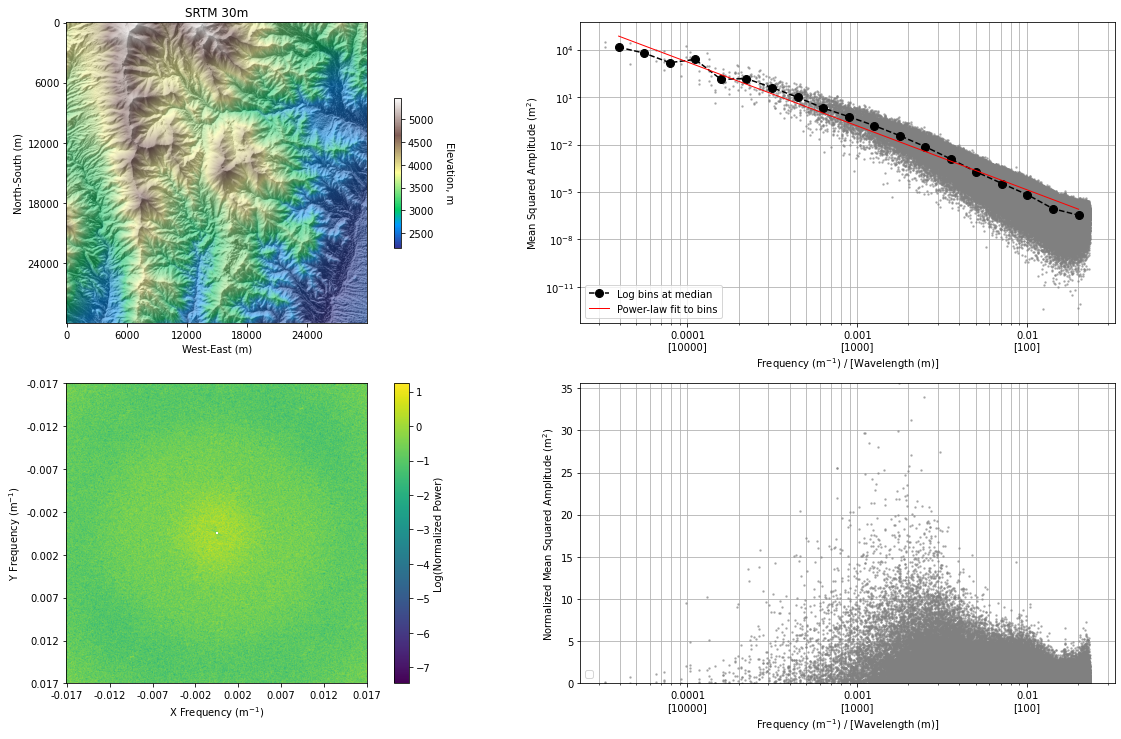

In [13]:
# make a figure
fig, axes = plt.subplots(2, 2, figsize=(19.2, 10.8),
                               gridspec_kw={'left':0.1, 'right':0.95, 
                                            'bottom':0.1, 'top':0.95})
ax1, ax2, ax3, ax4 = axes[0, 1], axes[1, 1], axes[0, 0], axes[1, 0]

# first plot the original 1D power specturm
ax1.loglog(f1d[::skip], p1d[::skip], '.', c='gray', alpha=0.5, markersize=3, Label="Power",
          rasterized=True)
ax1.loglog(bin_center, bin_med, 'ko--', markersize=8, alpha=1, 
          label="Log bins at median")
ax1.loglog(bin_center, pl_fit, 'r-', lw=1, label="Power-law fit to bins")
ax1.set_xticklabels(["{:}\n[{:.0f}]".format(a, 1/a) for a in ax1.get_xticks()])
ax1.set_xlabel('Frequency (m$^{-1}$) / [Wavelength (m)]')
ax1.set_ylabel('Mean Squared Amplitude (m$^2$)')
ax1.grid(True, which="both")
ax1.legend(loc='lower left', fontsize=10)

# then plot the normalized 1D power specturm
ax2.semilogx(f1d[::skip], p1d_norm[::skip], '.', c='gray', alpha=0.5, markersize=3, Label="Power",
          rasterized=True)
ax2.set_ylim(0, p1d_norm.max())
ax2.set_xticklabels(["{:}\n[{:.0f}]".format(a, 1/a) for a in ax2.get_xticks()])
ax2.set_xlabel('Frequency (m$^{-1}$) / [Wavelength (m)]')
ax2.set_ylabel('Normalized Mean Squared Amplitude (m$^2$)')
ax2.grid(True, which="both")
ax2.legend(loc='lower left', fontsize=10)

# now plot the original DEM
im = ax3.imshow(z_original, cmap='terrain') 
cbar = plt.colorbar(im, ax=ax3, shrink=0.5)
cbar.set_label('Elevation, m', rotation=270, labelpad=20)
ax3.imshow(hs, cmap='Greys', alpha=0.5)
# these next lines add some labels
ax3.set_xticklabels(["{:.0f}".format(x * step) for x in ax3.get_xticks()])
ax3.set_yticklabels(["{:.0f}".format(y * step) for y in ax3.get_yticks()])
ax3.set_xlabel("West-East (m)")
ax3.set_ylabel("North-South (m)")
ax3.set_title(fn)

# also plot the normalized 2D power spectrum
im = ax4.imshow(np.log10(p2d_norm))
fig.colorbar(im, ax=ax4, label="Log(Normalized Power)")
ax4.set_xlabel("X Frequency (m$^{-1}$)")
ax4.set_ylabel("Y Frequency (m$^{-1}$)")
nfy, nfx = f2d.shape
nyq = f2d[nfy//2 + 1, 0]
n_labels = 8
ax4.set_xticks(np.linspace(1, nfx, n_labels))
ax4.set_yticks(np.linspace(1, nfy, n_labels))
ticks = ["{:.3f}".format(a) for a in np.linspace(-nyq, nyq, n_labels)]
ax4.set_xticklabels(ticks)
ax4.set_yticklabels(ticks)

plt.show()

# What do we see here?

It looks like the SRTM power spectrum is fairly smooth with some higher values around ~800-1000 m. This length scale corresponds to the approximate spacing of the small scale ridges and valleys throughout the image. This peak in power is, however, rather diffuse over a large wavelength range since the DEM area selected contains many features of smaller and larger size. We do not see any really noticeable high frequency noise at lower wavelength (< 100 m), which might be cause for concern...

## What about for ASTER?

Let's have a look at our other dataset below.

### First let's change the variables

In [14]:
# set a few variables
fn = "ASTER 30m"
z = aster_dem
hs = aster_hs
step = aster_step
skip = 1 # plot every n-th power value, for large grids (>2000*2000 pixels) use a skip of 2 or 3

### For this run, we'll just do it all in one block to get a quick figure for comparison

No handles with labels found to put in legend.


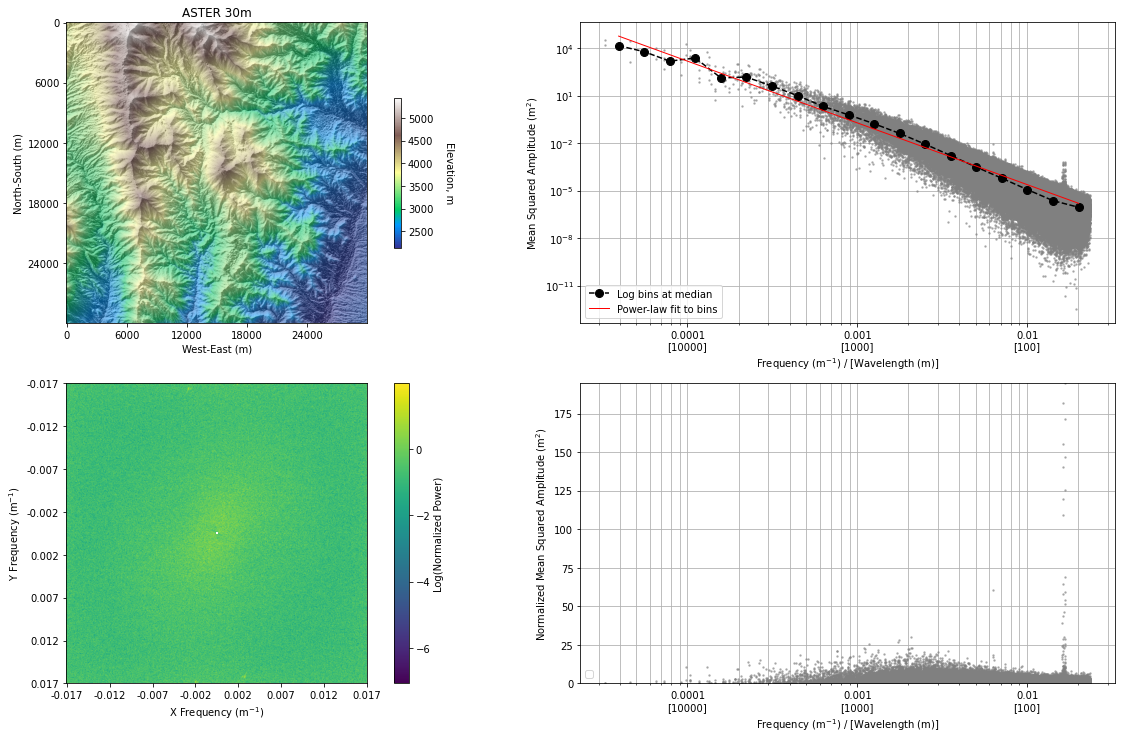

In [15]:
# get the size of the raster and save a copy of the original grid
z_original = z.copy()
ny, nx = z.shape

# use linear algebra to fit a plane by least squares
x, y = np.meshgrid(range(nx), range(ny))
A = np.vstack([x.ravel(), y.ravel(), np.ones(len(x.ravel()))]).T
fit = np.linalg.lstsq(A, z.ravel(), rcond=None)[0]
z = z - (fit[0]*x + fit[1]*y + fit[2])

# apply hanning windowing to reduce spectral leakage on edges
hann_y = np.hanning(ny)
hann_x = np.hanning(nx)
hann_2d = np.sqrt(np.outer(hann_y, hann_x))
hann_weight = np.sum(hann_2d ** 2)
z = z * hann_2d

# This next step is done to optimize the Cooley and Turkey (1965) 
# Discrete Fourier Transfom (DFT) method used by numpy, which operates 
# most efficiently when the length scales are powers of 2 and the grid
# is square
Lx = int(2**(np.ceil(np.log(np.max((nx, ny)))/np.log(2))))
Ly = Lx

# run the fft
fft = np.fft.fftn(z, (Ly, Lx))

# shift zero frequency to center
fft_shift = np.fft.fftshift(fft)

# # index of zero frequency (DC component)
xc, yc = (Lx//2, Ly//2)

# # zero out the DC component
fft_shift[yc, xc] = 0

# get the DFT periodogram with units of m^2 for topography
# include weights of hann to correct for windowing
p2d = np.abs(fft_shift)**2 / (Lx * Ly * hann_weight)

# The periodogram is a measure of how much of the
# original elevation field's variance falls within a given frequency range.
# You can check that the sum of the periodogram is roughly equal to the
# variance in Z. (The variance will be somewhat less due to the zero padding.)

# calculate radial frequencies
# xc, yc = (Lx//2, Ly//2) # (Lx//2 + 1, Ly//2 - 1) # center coordinate
x, y = np.meshgrid(range(Lx), range(Ly))#[::-1])

# wavenumbers
kx = x - xc
ky = y - yc
# kx_, ky_ = np.meshgrid(range(-Lx//2, Lx//2 - 1), range(Ly//2, -Ly//2+1, -1))

# radial frequencies
fx = kx / (Lx * step)
fy = ky / (Ly * step)
f2d = np.sqrt(fx**2 + fy**2)
# w2d = np.sqrt((1/fx)**2 + (1/fy)**2)
# f2d = 1/w2d

# fourier angles
F_ang2d = np.rad2deg(np.arctan2(ky*step, kx*step))

# Create sorted, non-redundant vectors of frequency and power
p1d = p2d[:, 0:xc+1].copy() # only half the power (reflected across the center)
f1d = f2d[:, 0:xc+1].copy() # same for the frequency
F_ang1d = F_ang2d[:, 0:xc+1].copy() # same for angle

# set reundant columns to negative for clipping below
f1d[yc:Ly, xc] = -1

# concatenate frequency and power and sort by frequency
f1d = np.c_[f1d.ravel(), p1d.ravel(), F_ang1d.ravel()]
I = np.argsort(f1d[:, 0])
f1d = f1d[I, :]

# remove negative values
f1d = f1d[f1d[:, 0] > 0, :]

# extract power, angle, and frequency (factor of 2 corrects for taking half the spectrum)
p1d = 2 * f1d[:, 1] # the sum of the p2d and p1d should now be approximately equal
F_ang1d = f1d[:, 2]
f1d = f1d[:, 0]

# bin the data using log bins
bins = 20
f_bins = np.logspace(np.log10(f1d.min()), np.log10(f1d.max()), num=bins)
bin_med, edges, _ = stats.binned_statistic(f1d, p1d, statistic=np.nanmedian, 
                                  bins=f_bins)
bin_center = edges[:-1] + np.diff(edges)/2

# sometimes NaN values remain in some bins, throw those bins out
bin_center = bin_center[np.isfinite(bin_med)]
bin_med = bin_med[np.isfinite(bin_med)]

# apply a power-law fit to the bins
A = np.vstack([np.log10(bin_center), np.ones(len(bin_center))]).T
fit = np.linalg.lstsq(A, np.log10(bin_med), rcond=None)[0]
pl_fit = (10**fit[1]) * (bin_center**fit[0])

# use the power-law fit to normalize the 1D spectrum
p1d_norm = p1d / ((10**fit[1]) * (f1d**fit[0]))

# use the power-law fit to normalize the 2D spectrum
p2d_norm = p2d / ((10**fit[1]) * (f2d**fit[0]))

# make a figure
fig, axes = plt.subplots(2, 2, figsize=(19.2, 10.8),
                               gridspec_kw={'left':0.1, 'right':0.95, 
                                            'bottom':0.1, 'top':0.95})
ax1, ax2, ax3, ax4 = axes[0, 1], axes[1, 1], axes[0, 0], axes[1, 0]

# first plot the original 1D power specturm
ax1.loglog(f1d[::skip], p1d[::skip], '.', c='gray', alpha=0.5, markersize=3, Label="Power",
          rasterized=True)
ax1.loglog(bin_center, bin_med, 'ko--', markersize=8, alpha=1, 
          label="Log bins at median")
ax1.loglog(bin_center, pl_fit, 'r-', lw=1, label="Power-law fit to bins")
ax1.set_xticklabels(["{:}\n[{:.0f}]".format(a, 1/a) for a in ax1.get_xticks()])
ax1.set_xlabel('Frequency (m$^{-1}$) / [Wavelength (m)]')
ax1.set_ylabel('Mean Squared Amplitude (m$^2$)')
ax1.grid(True, which="both")
ax1.legend(loc='lower left', fontsize=10)

# then plot the normalized 1D power specturm
ax2.semilogx(f1d[::skip], p1d_norm[::skip], '.', c='gray', alpha=0.5, markersize=3, Label="Power",
          rasterized=True)
ax2.set_ylim(0, p1d_norm.max())
ax2.set_xticklabels(["{:}\n[{:.0f}]".format(a, 1/a) for a in ax2.get_xticks()])
ax2.set_xlabel('Frequency (m$^{-1}$) / [Wavelength (m)]')
ax2.set_ylabel('Normalized Mean Squared Amplitude (m$^2$)')
ax2.grid(True, which="both")
ax2.legend(loc='lower left', fontsize=10)

# now plot the original DEM
im = ax3.imshow(z_original, cmap='terrain') 
cbar = plt.colorbar(im, ax=ax3, shrink=0.5)
cbar.set_label('Elevation, m', rotation=270, labelpad=20)
ax3.imshow(hs, cmap='Greys', alpha=0.5)
# these next lines add some labels
ax3.set_xticklabels(["{:.0f}".format(x * step) for x in ax3.get_xticks()])
ax3.set_yticklabels(["{:.0f}".format(y * step) for y in ax3.get_yticks()])
ax3.set_xlabel("West-East (m)")
ax3.set_ylabel("North-South (m)")
ax3.set_title(fn)

# also plot the normalized 2D power spectrum
im = ax4.imshow(np.log10(p2d_norm))
fig.colorbar(im, ax=ax4, label="Log(Normalized Power)")
ax4.set_xlabel("X Frequency (m$^{-1}$)")
ax4.set_ylabel("Y Frequency (m$^{-1}$)")
nfy, nfx = f2d.shape
nyq = f2d[nfy//2 + 1, 0]
n_labels = 8
ax4.set_xticks(np.linspace(1, nfx, n_labels))
ax4.set_yticks(np.linspace(1, nfy, n_labels))
ticks = ["{:.3f}".format(a) for a in np.linspace(-nyq, nyq, n_labels)]
ax4.set_xticklabels(ticks)
ax4.set_yticklabels(ticks)

plt.show()

# Voilà! High-frequency noise!

We see here the diffuse ~800-1000 m landscape frequency is now obscured by a huge power spike around ~90 m (or three ASTER pixels). This is the high-frequency noise so prevelant in optically generated DEMs, which you can read more about here:

https://www.earth-surf-dynam.net/5/211/2017/